In [1]:
import numpy as np
import matplotlib.pyplot as plt
from evaluation_functions import load_data, preprocess_corpus
import time
from src.ir_evaluation import Evaluator
from vectoriel import Vectoriel

# inheritance to modify method quickly (to normalize vector)
class VectorielNorm(Vectoriel):

    def __init__(self, corpus_tokenized, normalize=True):
        """
        :param corpus_tokenized: list of documents tokenized
        """
        Vectoriel.__init__(self, corpus_tokenized)
        self.normalize = normalize

    def descripteur_ensembliste_document(self, document_bagwords, tf_idf=True):
        """
        Creates tf-idf descriptor
        :param document_bagwords: must be bag words dict {"word" : frequency}
        :param tf_idf: boolean True to compute idf else False
        :return: dict{"token" : idf * frequency} if tf_idf True else dict{"token" : frequency}
        """
        result = dict()
        # init all words to 0
        for word in self.vocabulary:
            result[word] = 0
        # add frequency
        for word in document_bagwords:
            if word in self.vocabulary:
                # this if statement is made to avoid to add unknown words from queries
                tf = document_bagwords[word]
                if not tf_idf:
                    idf = 1
                else:  # compute idf
                    idf = self.compute_idf(word)
                result[word] = tf * idf

        #normalize vector
        if self.normalize:
            vect = list(result.values())
            norm = np.linalg.norm(vect, 1)
            for word, tf in zip(result, vect):
                result[word] = tf / norm
        return result

In [2]:
def eval_tfidf_norm(dataset_name='med', tf_idf=True, stop_words=True, stemm=True, bag_words=True, normalize=True):
    """
    Evaluates performances of ensembliste SRI with a given dataset name
    Boolean parameters allows to see their impacts in the SRI performances
    :param normalize: boolean to make vector norm = 1
    :param tf_idf: boolean
    :param dataset_name: str
    :param stop_words: boolean
    :param stemm: boolean
    :param bag_words: boolean
    :return: dictionary 'result'
    """
    dataset, queries, ground_truth = load_data(dataset_name)
    stop_list = np.genfromtxt('data/stoplist/stoplist-english.txt', dtype='str')
    dataset_bagwords = preprocess_corpus(dataset, stop_list, stop_words=stop_words, stemm=stemm, bag_words=bag_words)

    ground_truth_dict = dict()
    ground_truth_dict['groundtruth'] = ground_truth

    vectoriel = VectorielNorm(dataset_bagwords, normalize=normalize)
    result = dict()

    # Inverted index
    # Compute time to build inverted index
    start_inverted_build = time.time()
    index_inverted = vectoriel.inverted_index_construction(dataset_bagwords, tf_idf=tf_idf)
    stop_inverted_build = time.time()
    result['inverted_build_time'] = stop_inverted_build - start_inverted_build

    # Compute time to search in inverted index
    start_search_inverted = time.time()
    eval_inverted_all_queries = vectoriel.search_all_queries(queries, inverted=True, tf_idf=tf_idf,
                                                             stop_words=stop_words, stemm=stemm, bag_words=bag_words)
    end_search_inverted = time.time()
    result['inverted_search_time'] = end_search_inverted - start_search_inverted

    # Evaluate performances (recall precision)
    eval_inverted = Evaluator(retrieved=eval_inverted_all_queries, relevant=ground_truth_dict)
    result["evaluation_inverted"] = eval_inverted.evaluate_pr_points()

    result["MAP inverted"] = eval_inverted.evaluate_map()

    return result

In [3]:
dataset = 'med'
results = dict()

In [4]:
results["norm"] = eval_tfidf_norm(dataset, stop_words=True, stemm=True, bag_words=True, normalize=True)

In [5]:
results["no_norm"] = eval_tfidf_norm(dataset, stop_words=True, stemm=True, bag_words=True, normalize=False)

In [6]:
def plot_precision_recall(evaluation_list, labels):
    """
    Plots multiple recall-precision curves on same plot (for comparison)
    :param evaluation_list: list of tuples [(x1, y1), (x2, y2), ...]
    :param labels: curves title
    :return: None
    """
    for evaluation, label in zip(evaluation_list, labels):
        plt.plot([e[0] for e in evaluation], [e[1] for e in evaluation], label=label)
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()

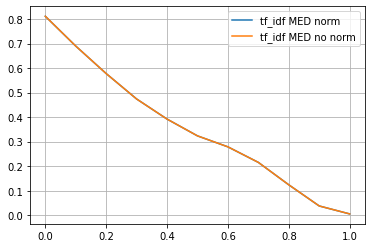

In [7]:
plot_precision_recall([results['norm']['evaluation_inverted'], results['no_norm']['evaluation_inverted']], ['tf_idf MED norm', 'tf_idf MED no norm'])
plt.show()